## EfficientNetB3 + CBAM

In [1]:
# ✅ Step 1: Import Required Libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns

2025-06-30 01:14:08.228760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751246048.648026      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751246048.767026      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Paths (update if different)
base_dir = '/kaggle/input/eyepacs-aptos-messidor-diabetic-retinopathy/augmented_resized_V2'  # Change if needed
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Image dimensions
IMG_SIZE = 224 
BATCH_SIZE = 32
NUM_CLASSES = 5

In [3]:
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Only resizing + EfficientNet normalization (no augmentation)
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Create generators
train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 115241 images belonging to 5 classes.
Found 14227 images belonging to 5 classes.
Found 14201 images belonging to 5 classes.


In [9]:
from tensorflow.keras import layers

class CBAM(layers.Layer):
    def __init__(self, ratio=8):
        super(CBAM, self).__init__()
        self.ratio = ratio

    def build(self, input_shape):
        channel = input_shape[-1]

        # Channel Attention components
        self.shared_dense_one = layers.Dense(channel // self.ratio,
                                             activation='relu',
                                             kernel_initializer='he_normal',
                                             use_bias=True)
        self.shared_dense_two = layers.Dense(channel,
                                             kernel_initializer='he_normal',
                                             use_bias=True)

        # Spatial Attention components
        self.conv_spatial = layers.Conv2D(filters=1,
                                          kernel_size=7,
                                          padding='same',
                                          activation='sigmoid',
                                          kernel_initializer='he_normal',
                                          use_bias=False)

    def call(self, input_feature):
        # --- Channel Attention ---
        avg_pool = tf.reduce_mean(input_feature, axis=[1, 2], keepdims=True)
        max_pool = tf.reduce_max(input_feature, axis=[1, 2], keepdims=True)

        avg_out = self.shared_dense_two(self.shared_dense_one(avg_pool))
        max_out = self.shared_dense_two(self.shared_dense_one(max_pool))
        channel_attention = tf.nn.sigmoid(avg_out + max_out)
        x = input_feature * channel_attention

        # --- Spatial Attention ---
        avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        spatial_attention = self.conv_spatial(concat)
        refined_feature = x * spatial_attention

        return refined_feature

In [10]:
# Load base model
base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True

# Define model with CBAM
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=True)
x = CBAM()(x)  # ✅ CBAM Layer added correctly
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model_cbam = tf.keras.Model(inputs, outputs)
model_cbam.compile(optimizer=optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1751246235.454553      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751246235.455347      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
model_cbam.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 7, 7, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cbam (CBAM)                          │ (None, 7, 7, 1536)          │         591,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,777,110 (44.93 MB)

 Trainable params: 11,686,223 (44.58 MB)

 Non-trainable params: 90,887 (355.03 KB)

In [12]:
checkpoint_cb = callbacks.ModelCheckpoint('/kaggle/working/best_Cbam_efficientnetb3_dr.h5', save_best_only=True, monitor='val_loss')
earlystop_cb = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_cb = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

# Train the model
history = model_cbam.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1751246331.814243      83 service.cc:148] XLA service 0x78a2c80024c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751246331.815701      83 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751246331.815724      83 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751246340.380667      83 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1751246358.845464      83 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751246358.993670      83 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751246359.532214      83 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

1388/3602 ━━━━━━━━━━━━━━━━━━━━ 13:38 370ms/step - accuracy: 0.4386 - loss: 1.6842

E0000 00:00:1751246928.116832      82 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751246928.255912      82 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1760s 445ms/step - accuracy: 0.5286 - loss: 1.3887 - val_accuracy: 0.7564 - val_loss: 0.6684 - learning_rate: 1.0000e-04
Epoch 2/50
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 999s 277ms/step - accuracy: 0.7335 - loss: 0.7381 - val_accuracy: 0.7862 - val_loss: 0.6160 - learning_rate: 1.0000e-04
Epoch 3/50
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1000s 278ms/step - accuracy: 0.7830 - loss: 0.5973 - val_accuracy: 0.7960 - val_loss: 0.5880 - learning_rate: 1.0000e-04
Epoch 4/50
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1003s 278ms/step - accuracy: 0.8297 - loss: 0.4762 - val_accuracy: 0.7881 - val_loss: 0.6535 - learning_rate: 1.0000e-04
Epoch 5/50
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.8726 - loss: 0.3605
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1000s 278ms/step - accuracy: 0.8726 - loss: 0.3605 - val_accuracy: 0.7911 - val_loss: 0.6819 - learning_rate: 1.0000e-04
Epoch 6/50
3602/3602 ━━━━━━━━━━━━━━━━━━━━

In [13]:
import pickle

# Save history to disk
with open("E3_Cbam_training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

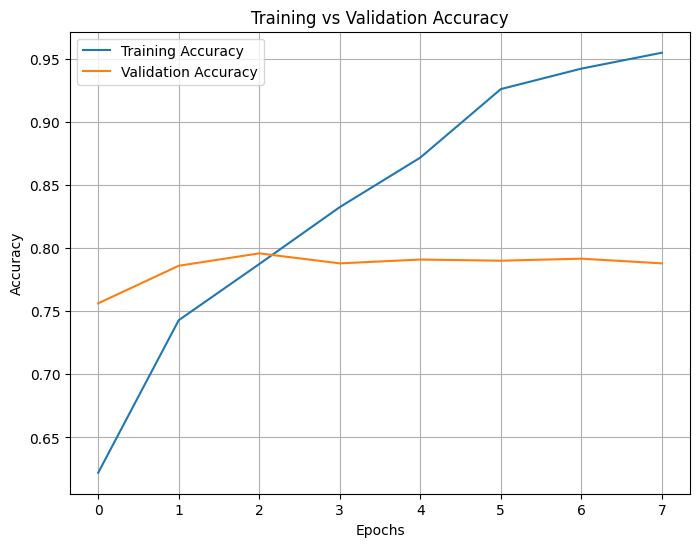

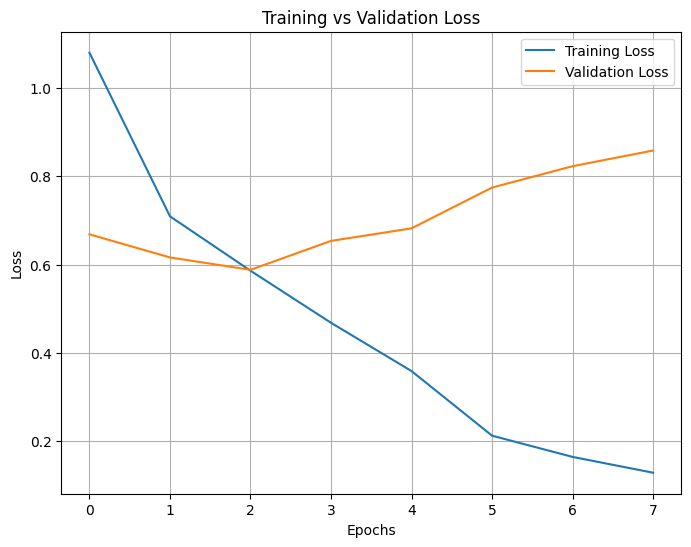

In [14]:
history_data = history.history

import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history_data['accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(history_data['loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/input/e3/keras/default/1/best_Cbam_efficientnetb3_dr.h5',
                   custom_objects={'CBAM': CBAM},
                   compile=False)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1751260879.902801     117 service.cc:148] XLA service 0x7aa19c001720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751260879.903517     117 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751260879.903536     117 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751260880.935087     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/444 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step   

I0000 00:00:1751260888.711988     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


444/444 ━━━━━━━━━━━━━━━━━━━━ 164s 338ms/step
📊 Classification Report:
              precision    recall  f1-score   support

           0     0.6261    0.9951    0.7686      6896
           1     0.3848    0.0682    0.1159      1862
           2     0.4451    0.2908    0.3518      2999
           3     0.5993    0.1851    0.2828       978
           4     0.8077    0.3581    0.4962      1466

    accuracy                         0.6033     14201
   macro avg     0.5726    0.3794    0.4031     14201
weighted avg     0.5731    0.6033    0.5334     14201



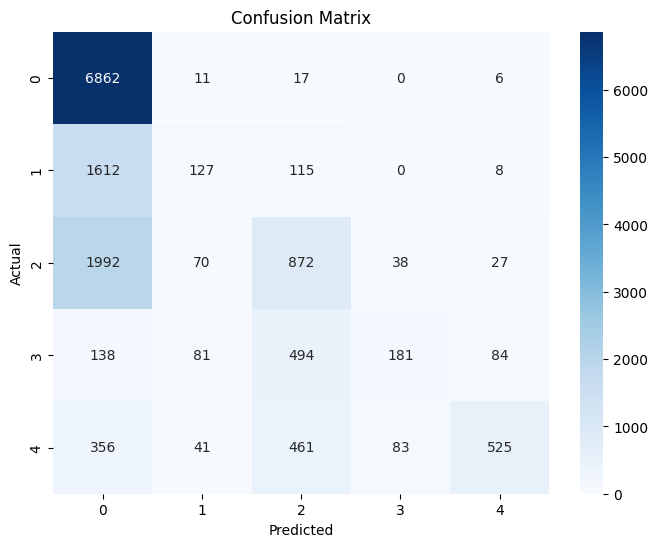

🧠 Quadratic Weighted Kappa (QWK): 0.5876


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data
y_true = test_gen.classes
y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)

# Classification report
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices, yticklabels=test_gen.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# QWK Score
qwk = cohen_kappa_score(y_true, y_pred, weights='quadratic')
print(f"🧠 Quadratic Weighted Kappa (QWK): {qwk:.4f}")